### 📝 Project Title: Customer Lifetime Value (CLV) Prediction Using BG/NBD and Gamma-Gamma Models


## 📌 Introduction

In today’s competitive retail environment, understanding and predicting customer value is essential for strategic decision-making. This project leverages the UCI Online Retail Dataset to estimate Customer Lifetime Value (CLV) using probabilistic models. Specifically, the BG/NBD (Beta Geometric/Negative Binomial Distribution) and Gamma-Gamma models are applied to capture purchasing frequency and monetary value respectively.


The goal is to identify high-value customers and support data-driven marketing strategies such as personalized offers, customer segmentation, and retention efforts.



## 🧾 Dataset Overview

Source: UCI Machine Learning Repository – Online Retail

Data Range: December 2010 – December 2011

Key Columns:

InvoiceNo: Unique transaction code

StockCode: Product identifier

Description: Product name

Quantity: Units purchased

InvoiceDate: Date of transaction

UnitPrice: Price per unit

CustomerID: Unique customer ID

Country: Country of customer



## ⚙️ Tools and Libraries

Programming Language: Python

Libraries:

pandas, numpy: Data manipulation

lifetimes: CLV modeling

matplotlib, seaborn: Visualization



## 🧼 Data Preprocessing

Steps:

Removed null CustomerIDs

Filtered out cancelled/negative transactions

Created TotalPrice as Quantity * UnitPrice

Parsed and standardized InvoiceDate


## 📊 Modeling Approach

1. BG/NBD Model – Predict Purchase Frequency
   
The BG/NBD model estimates:

How often a customer will make a purchase in a given time window

The probability that a customer is still "alive" (i.e., active)

2. Gamma-Gamma Model – Predict Average Spend
   
This model assumes:

Transaction monetary value is independent of purchase frequency

Gamma distributions govern individual-level monetary averages

3. CLV Estimation
   
CLV is calculated over a 6-month horizon with a monthly discount rate.


## 📈 Results and Insights

Predicted future purchases and monetary values for each customer

Identified top 10 customers with the highest CLV

Generated visual insights to support business targeting


## ✅ Conclusion

This project demonstrates how probabilistic models can be applied to real-world e-commerce data to derive actionable insights. By using BG/NBD and Gamma-Gamma models, we accurately estimated future customer behavior and value, enabling more informed marketing strategies.



In [1]:
import pandas as pd
import numpy as np
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import summary_data_from_transaction_data
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#Load data
df = pd.read_excel(r"C:\Users\SD\Downloads\online+retail\Online Retail.xlsx")

In [3]:
df.head(1)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom


In [4]:
# Basic cleaning

df.dropna(subset=['CustomerID'], inplace=True)

df = df[df['Quantity'] > 0]

df = df[df['UnitPrice'] > 0]

In [5]:
# Create TotalPrice column

df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [7]:
# Remove refunds (Invoice starting with "C")
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')]

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 397884 entries, 0 to 541908
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    397884 non-null  object        
 1   StockCode    397884 non-null  object        
 2   Description  397884 non-null  object        
 3   Quantity     397884 non-null  int64         
 4   InvoiceDate  397884 non-null  datetime64[ns]
 5   UnitPrice    397884 non-null  float64       
 6   CustomerID   397884 non-null  float64       
 7   Country      397884 non-null  object        
 8   TotalPrice   397884 non-null  float64       
dtypes: datetime64[ns](1), float64(3), int64(1), object(4)
memory usage: 30.4+ MB


In [9]:

# Use UK customers only for simplicity
df = df[df['Country'] == 'United Kingdom']

In [11]:
df['Country'].value_counts()

Country
United Kingdom    354321
Name: count, dtype: int64

In [12]:
# Create summary (RFM) data for lifetimes

snapshot_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

summary = summary_data_from_transaction_data(
    df, 'CustomerID', 'InvoiceDate', monetary_value_col='TotalPrice', observation_period_end=snapshot_date
)

In [13]:
# Filter out customers with zero monetary value
summary = summary[summary['monetary_value'] > 0]


In [15]:
summary.head(2)

,frequency,recency,T,monetary_value
CustomerID,,,,
12747.0,10.0,367.0,370.0,383.745000
12748.0,112.0,373.0,374.0,301.024821


In [16]:
# Fit BG/NBD model (transaction frequency model)
bgf = BetaGeoFitter(penalizer_coef=0.001)

bgf.fit(summary['frequency'], summary['recency'], summary['T'])

<lifetimes.BetaGeoFitter: fitted with 2522 subjects, a: 0.01, alpha: 107.67, b: 0.19, r: 1.90>

In [17]:
# Predict transactions for next 6 months

summary['predicted_purchases_6m'] = bgf.conditional_expected_number_of_purchases_up_to_time(
    180, summary['frequency'], summary['recency'], summary['T']
)


In [18]:
# Fit Gamma-Gamma model (monetary value model)
ggf = GammaGammaFitter(penalizer_coef=0.001)


ggf.fit(summary['frequency'], summary['monetary_value'])

<lifetimes.GammaGammaFitter: fitted with 2522 subjects, p: 11.13, q: 0.86, v: 11.33>

In [19]:
# Predict average monetary value
summary['expected_avg_value'] = ggf.conditional_expected_average_profit(
    summary['frequency'], summary['monetary_value']
)

In [20]:
# Compute 6-month CLV

summary['clv_6m'] = ggf.customer_lifetime_value(
    bgf, summary['frequency'], summary['recency'], summary['T'],
    summary['monetary_value'], time=6, discount_rate=0.01
)

In [21]:
# View top customers by CLV

top_customers = summary.sort_values('clv_6m', ascending=False).head(10)

print(top_customers[['clv_6m', 'predicted_purchases_6m', 'expected_avg_value']])

                   clv_6m  predicted_purchases_6m  expected_avg_value
CustomerID                                                           
16446.0     258985.367648                1.571334       170625.879255
18102.0      91775.441767               10.156743         9354.634331
17450.0      75368.890413               10.531844         7408.708304
14096.0      60204.929819               15.293802         4075.344499
17511.0      34422.441220               10.776053         3307.020123
16029.0      29043.083228               14.769538         2035.780065
16684.0      27620.757058                6.500738         4398.728484
13694.0      24429.151278               13.387113         1889.193522
15311.0      22204.314368               33.907314          677.952507
15769.0      22160.521751                8.571802         2676.471269


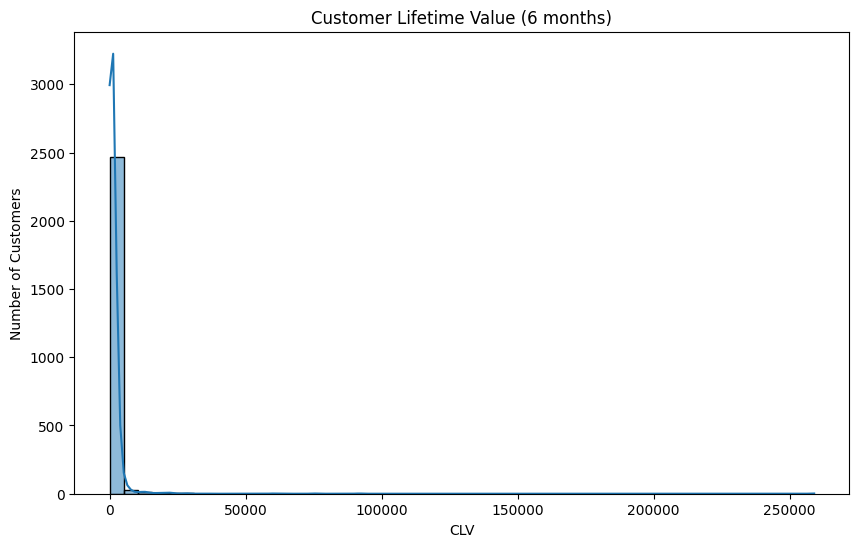

In [22]:
# Plot distribution of CLV
plt.figure(figsize=(10,6))
sns.histplot(summary['clv_6m'], bins=50, kde=True)
plt.title('Customer Lifetime Value (6 months)')
plt.xlabel('CLV')
plt.ylabel('Number of Customers')
plt.show()